In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
#!python '/content/drive/MyDrive/MLtiverse/train.py'

In [ ]:
import pandas as pd

a = pd.read_csv("/content/drive/MyDrive/MLtiverse/Train/captions.csv")
b = pd.read_csv("/content/drive/MyDrive/MLtiverse/train_set_2.csv")
b = b.dropna(axis=0)
a = a.dropna(axis=0)
print(a.shape)
print(b.shape)
merged = pd.concat([a,b])
print(merged.shape)

def train_test_split(df, frac=0.2):
    
    # get random sample 
    test = df.sample(frac=frac, axis=0)

    # get everything but the test sample
    train = df.drop(index=test.index)

    return train, test

train , valid = train_test_split(merged, frac=0.01)

print("train size : ", train.shape)
print("valid size : ", valid.shape)

train.to_csv("/content/drive/MyDrive/MLtiverse/train.csv")
valid.to_csv("/content/drive/MyDrive/MLtiverse/valid.csv")
merged.to_csv("/content/drive/MyDrive/MLtiverse/merged.csv") # for final training after hyper parameter tuning

(9736, 2)
(6550, 2)
(16286, 2)
train size :  (16000, 2)
valid size :  (163, 2)


In [ ]:
train.head(5)

id                                            Caption
0  110000    technician holding a snake removed from a house
1  110005   a city wears a gown for her wedding by the sea .
2  110006  fox can show us the skills necessary when it c...
3  110008           which contest - new yorker map of the us
4  110010         design , geometric tribal archaic emblem .

In [ ]:
valid.head(5)

id                                            Caption
7125  126202  slam : appeared on the cover of the 86th issue...
7425  126867        water slide from your bedroom to the pool !
590   133669                     eyes as windows to the world .
2945  139190  misses jacket , belt and dress b5952 i think i...
2681  116190                   bouquet of the bride near a tree

In [ ]:
data_location =  "/content/drive/MyDrive/MLtiverse/Train"
!ls $data_location

 Attention			  merged.csv
 captions.csv			  my_checkpoint_1.pth.tar
 CNN_RNN.pth.tar		  my_checkpoint_2.pth.tar
'Copy of my_checkpoint.pth.tar'   my_checkpoint_3.pth.tar
 Data				  my_checkpoint.pth.tar
 dataset_freq_2.pth.rar		  train.csv
 dataset.pth.rar		  valid.csv
'merged (1).csv'


In [ ]:
#reading the text data 
import pandas as pd
caption_file = data_location + '/train.csv'
df = pd.read_csv(caption_file)
print("There are {} image to captions".format(len(df)))
df.head(7)

There are 15998 image to captions


Unnamed: 0      id                                            Caption
0           0  110000    technician holding a snake removed from a house
1           1  110005   a city wears a gown for her wedding by the sea .
2           2  110006  fox can show us the skills necessary when it c...
3           3  110008           which contest - new yorker map of the us
4           4  110010         design , geometric tribal archaic emblem .
5           5  110012  a model wears a creation as part of fashion co...
6           6  110015  the grounds make for a beautiful destination w...

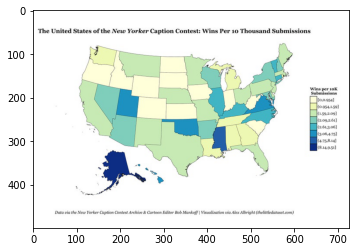

Caption: which contest - new yorker map of the us


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#select any index from the whole dataset 
#single image has 5 captions
#so, select indx as: 1,6,11,16...

i = 3

image_path = data_location + "/Data/"+str(df.iloc[i,1])+".jpg"
img=mpimg.imread(image_path)
plt.imshow(img)
plt.show()
print("Caption:",df.iloc[i,2])

Writing Custom Datasest

In [ ]:
#imports 
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
#using spacy for the better text tokenization 
spacy_eng = spacy.load("en")

#example
text = "This is a good place to find a city"
[token.text.lower() for token in spacy_eng.tokenizer(text)]

['this', 'is', 'a', 'good', 'place', 'to', 'find', 'a', 'city']

In [ ]:
class Vocabulary:
    def __init__(self,freq_threshold):
        #setting the pre-reserved tokens int to string tokens
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        
        #string to int tokens
        #its reverse dict self.itos
        self.stoi = {v:k for k,v in self.itos.items()}
        
        self.freq_threshold = freq_threshold
        
    def __len__(self): return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]

In [ ]:
#testing the vicab class 
v = Vocabulary(freq_threshold=1)

v.build_vocab(["This is a good place to find a city"])
print(v.stoi)
print(v.numericalize("This is a good place to find a city here!!"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 6, 'good': 7, 'place': 8, 'to': 9, 'find': 10, 'city': 11}
[4, 5, 6, 7, 8, 9, 10, 6, 11, 3, 3, 3]


In [ ]:
class Data(Dataset):
    """
    Data
    """
    def __init__(self,root_dir,captions_file,transform=None,freq_threshold=1):
        self.root_dir = root_dir
        self.df = pd.read_csv(caption_file)
        self.transform = transform
        
        #Get image and caption colum from the dataframe
        self.imgs = self.df["id"]
        self.captions = self.df["Caption"]
        
        #Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())
        
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,str(img_name)+".jpg")
        img = Image.open(img_location).convert("RGB")
        
        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)
        
        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)



In [ ]:
#defing the transform to be applied
transforms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

In [ ]:
def show_image(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

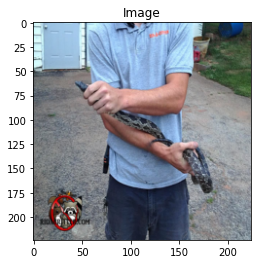

Token: tensor([ 1,  4,  5,  6,  7,  8,  9,  6, 10,  2])
Sentence:
['<SOS>', 'technician', 'holding', 'a', 'snake', 'removed', 'from', 'a', 'house', '<EOS>']


In [ ]:
#testing the dataset class
dataset =  Data(
    root_dir = data_location+"/Data",
    captions_file = data_location+"/merged.csv",
    transform=transforms
)



img, caps = dataset[0]
show_image(img,"Image")
print("Token:",caps)
print("Sentence:")
print([dataset.vocab.itos[token] for token in caps.tolist()])

In [ ]:
class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=True):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

In [ ]:
#writing the dataloader
#setting the constants
BATCH_SIZE = 4
NUM_WORKER = 1

#token to represent the padding
pad_idx = dataset.vocab.stoi["<PAD>"]

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

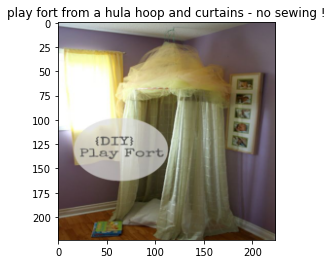

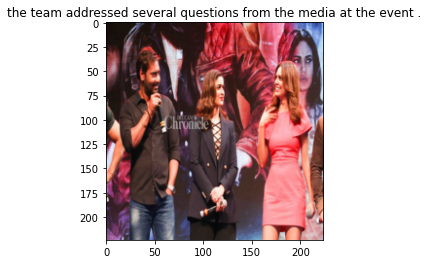

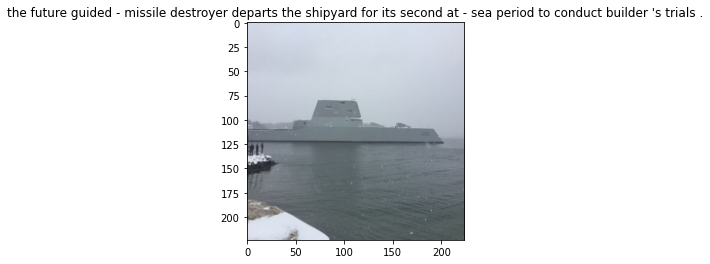

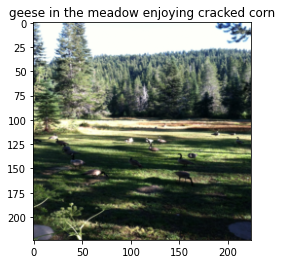

In [ ]:
#generating the iterator from the dataloader
dataiter = iter(data_loader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

#showing info of image in single batch
for i in range(BATCH_SIZE):
    img,cap = images[i],captions[i]
    caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)                      
    show_image(img,caption_label)
    plt.show()
    print("\n")

In [ ]:
#imports
import numpy as np
import torch
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T



In [ ]:
#show the tensor image
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
#Initiate the Dataset and Dataloader

#setting the constants
BATCH_SIZE = 16                  ############################################## check this
# BATCH_SIZE = 6
NUM_WORKER = 2

#defining the transform to be applied
transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])


#testing the dataset class
dataset = Data(
    root_dir = data_location+"/Data",
    captions_file = data_location+"/merged.csv",
    transform = transforms
)

def get_data_loader(
    dataset,
    batch_size=128,
    num_workers=2,
    shuffle=True,
    pin_memory=True,
):
    dataset = dataset

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=CapsCollate(pad_idx=pad_idx),
    )

    return loader ### check if we need to return dataset here ###########################


#writing the dataloader
data_loader = get_data_loader(
    dataset = dataset, 
    batch_size =BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle = True
    # batch_first=False
)

#vocab_size
vocab_size = len(dataset.vocab)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Building model

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        #print("features shape: ", features.shape)
        return features

In [ ]:
#Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
        
        
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights

In [ ]:
#Attention Decoder
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.1):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+ encoder_dim ,decoder_dim,bias=True)  
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim) 
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            #print("embeds shape : ", embeds.shape)
            #print("context shape: ",context.shape)
            lstm_input = torch.cat((embeds[:,s], context), dim=1) 
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = []
        
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas
    
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.1):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [ ]:
#Hyperparams
embed_size=800
vocab_size = len(dataset.vocab)
attention_dim=1024
encoder_dim=2048
decoder_dim=2048
learning_rate = 3e-4

In [ ]:
#init model
model = EncoderDecoder(
    embed_size=800,
    vocab_size = len(dataset.vocab),
    attention_dim=1024,
    encoder_dim=2048,
    decoder_dim=2048
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
#helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'/content/drive/MyDrive/MLtiverse/Train/Attention/attention_frq_1_model_state.pth')
    

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/MLtiverse/Train/Attention/sumbmissions/attention_model_sub_9_frq_1_state.pth')
model.load_state_dict(checkpoint["state_dict"])


<All keys matched successfully>

Epoch: 1 loss: 0.57032


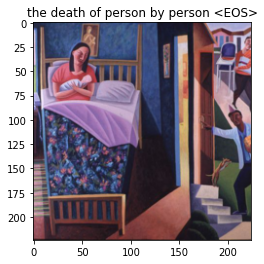

Epoch: 1 loss: 0.66678


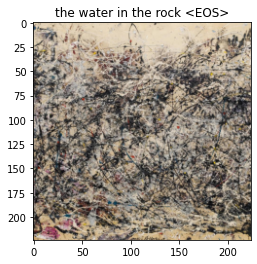

Epoch: 1 loss: 0.60438


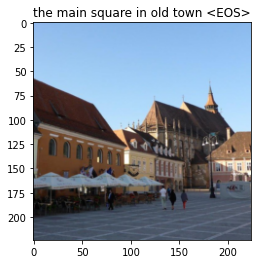

Epoch: 1 loss: 0.72940


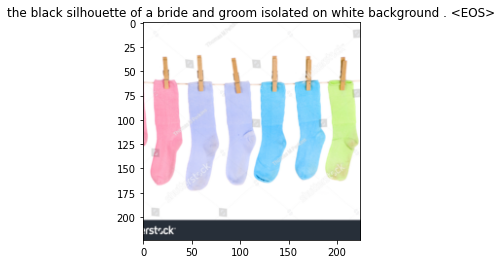

Epoch: 1 loss: 0.68041


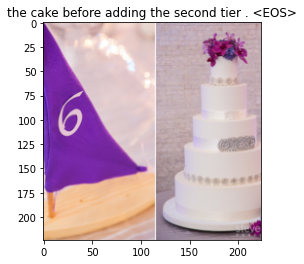

Epoch: 1 loss: 0.71300


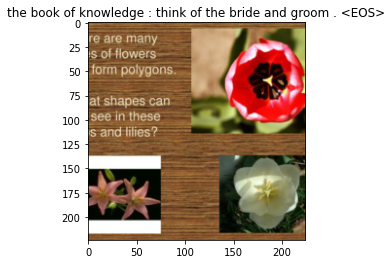

Epoch: 1 loss: 0.58688


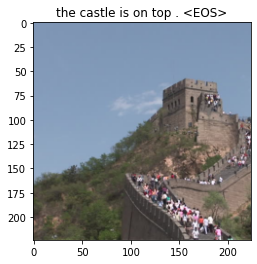

Epoch: 1 loss: 0.71288


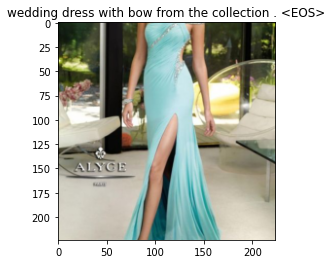

Epoch: 1 loss: 0.66113


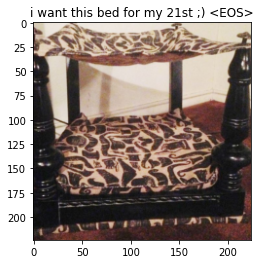

Epoch: 1 loss: 0.64772


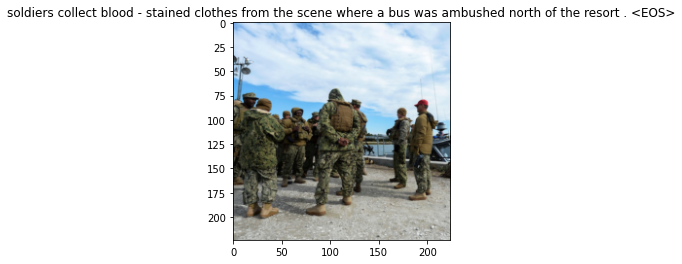

In [ ]:

num_epochs = 1
print_every = 100

for epoch in range(1,num_epochs+1):   
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            
            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)
                
            model.train()
        
    #save the latest model
    save_model(model,epoch)


Validation

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/MLtiverse/Test/sample.csv")
test_df.head(5)

id  Caption
0  140809      NaN
1  140810      NaN
2  140811      NaN
3  140813      NaN
4  140814      NaN

In [ ]:
#checkpoint = torch.load('/content/drive/MyDrive/MLtiverse/Train/Attention/attention_model_1_freq_1_state.pth')
#model.load_state_dict(checkpoint["state_dict"])

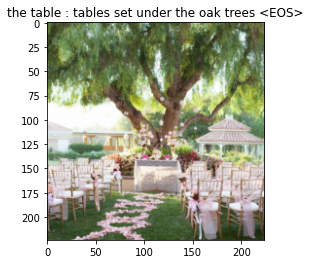

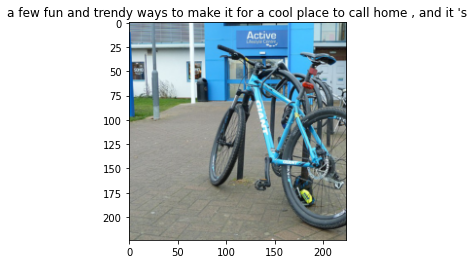

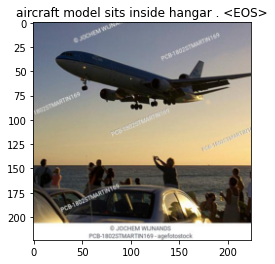

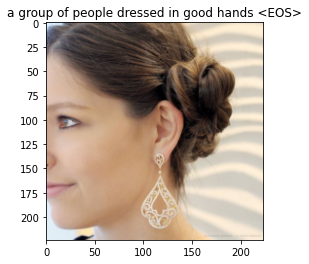

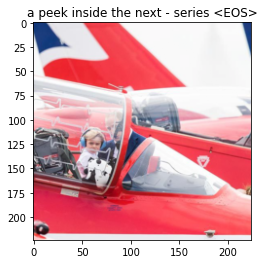

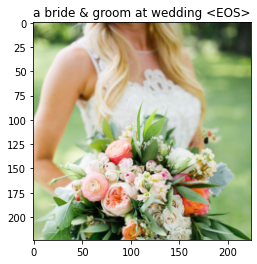

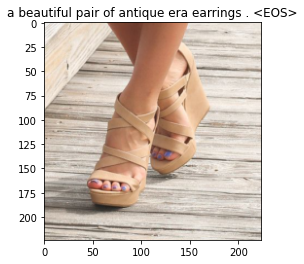

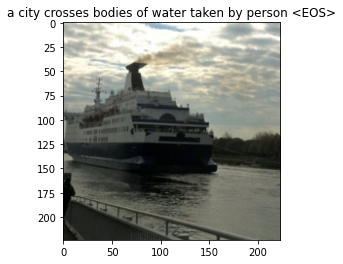

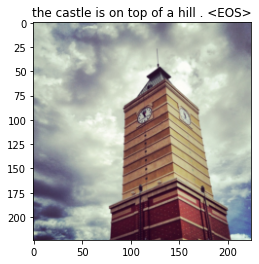

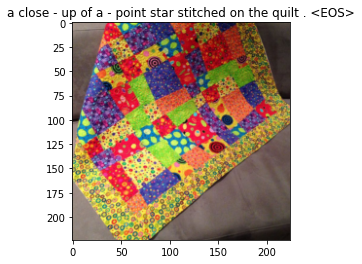

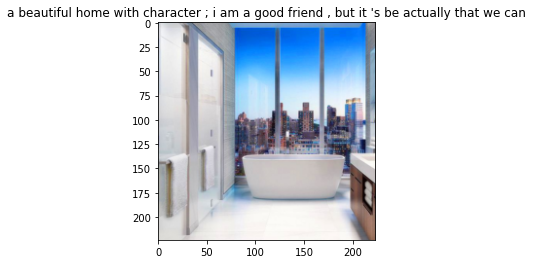

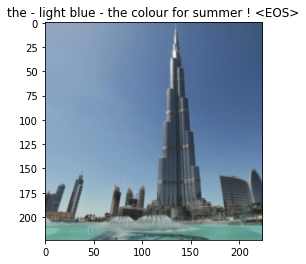

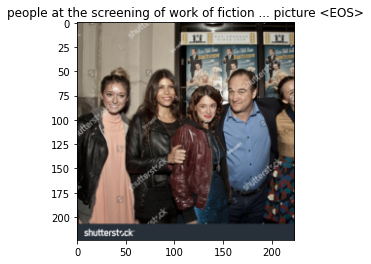

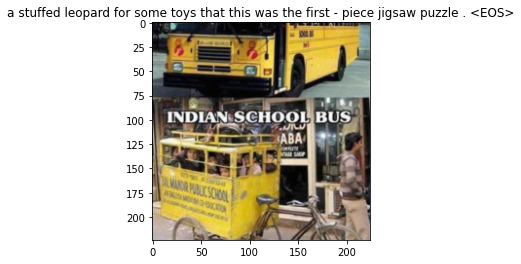

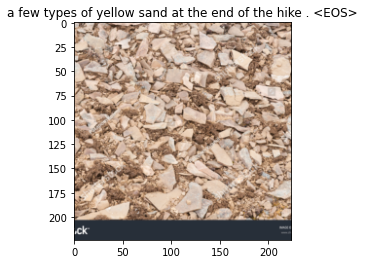

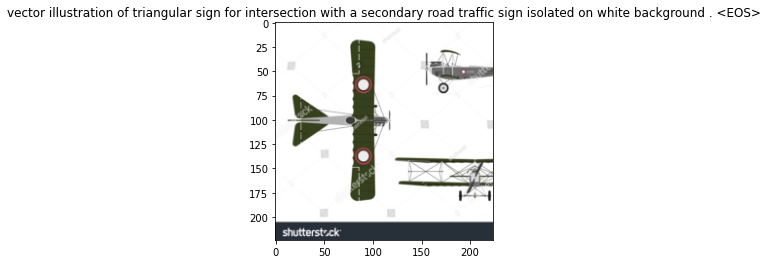

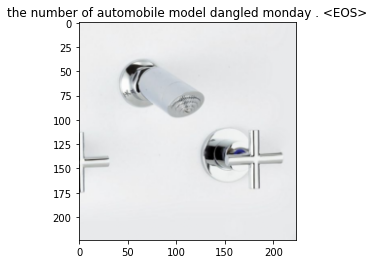

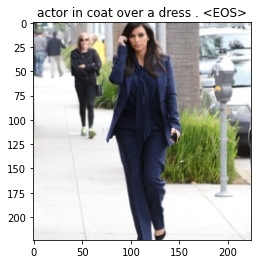

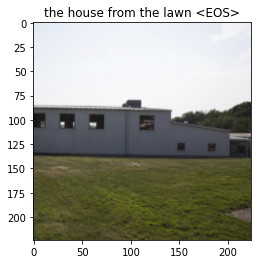

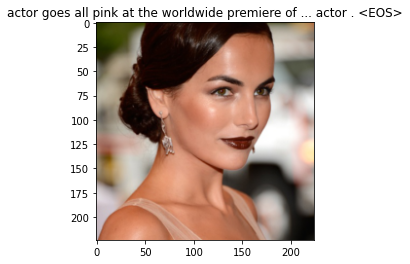

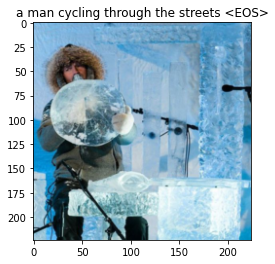

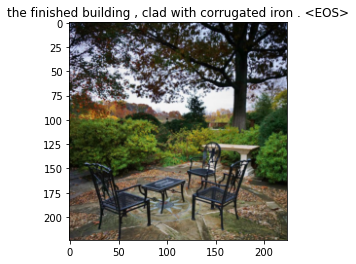

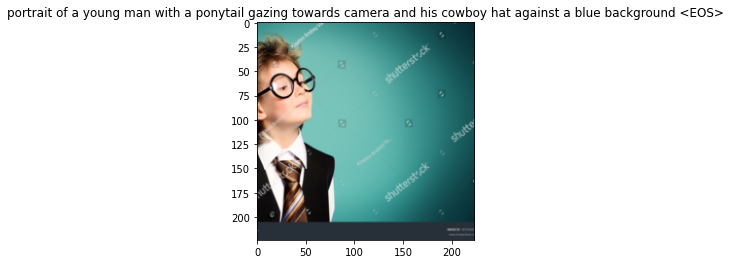

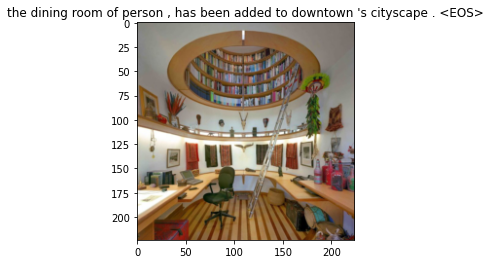

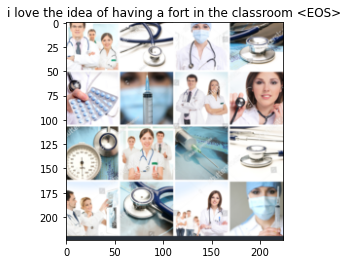

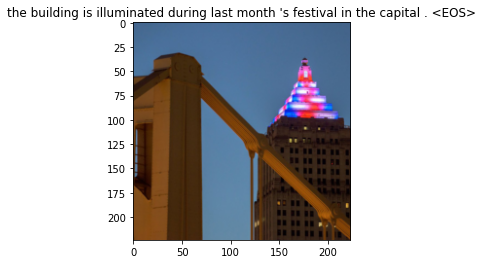

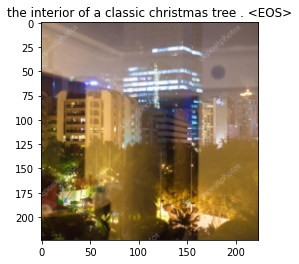

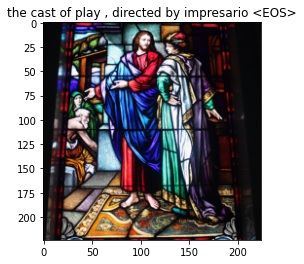

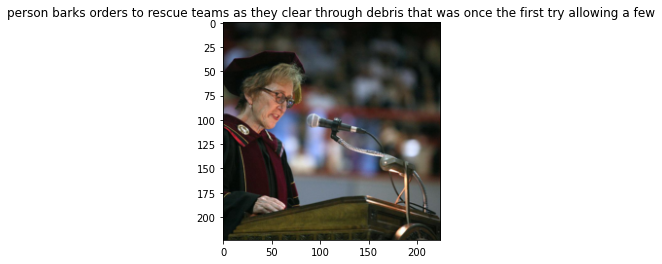

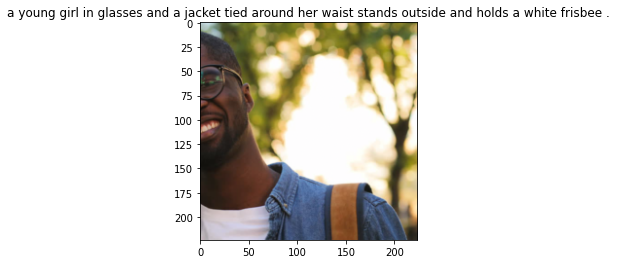

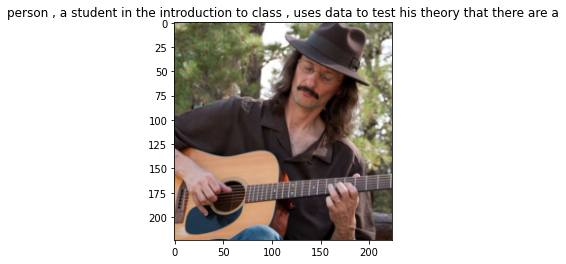

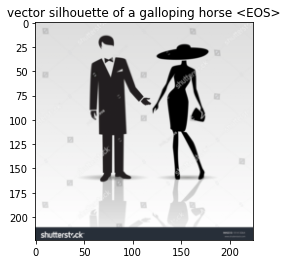

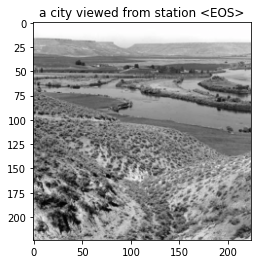

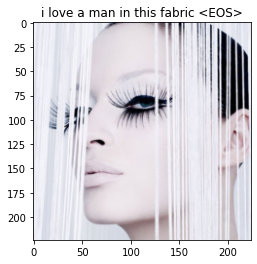

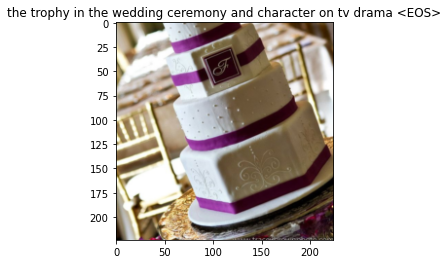

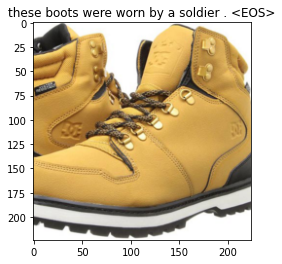

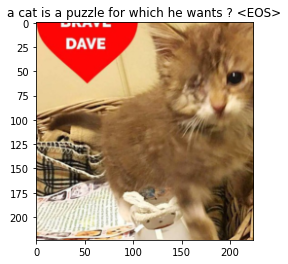

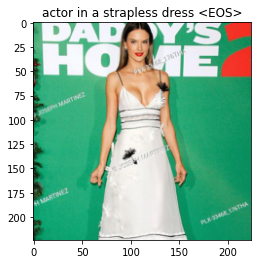

In [ ]:
v = []
i = 0 
model.eval()
for id in test_df['id']:
  img = transforms(Image.open("/content/drive/MyDrive/MLtiverse/Test/Test/"+ str(id)+".jpg").convert("RGB")).unsqueeze(0)    
  #caption = " ".join(model.caption_image(img.to(device), dataset.vocab))
  #v.append(caption)
  features = model.encoder(img[0:1].to(device))
  caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
  caption = ' '.join(caps)
  v.append(caption)
  if i % 100 == 0: 
    show_image(img[0],title=caption)
  i = i+1

In [ ]:
test_df['Caption'] = v
for i in range(len(test_df['Caption'])):
  test_df['Caption'][i] = test_df['Caption'][i][:-5]
test_df.to_csv("/content/drive/MyDrive/MLtiverse/test_freq_1.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
